In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList()
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        
    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

In [3]:
def derivatives_1(x, Net, func):
    
    w = Net(x)*(func(x).view(-1,1))
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return w, dw_x, dw_y

In [4]:
def derivatives_2(x, Net, func):
    
    w = Net(x)*(func(x).view(-1,1))
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)
    
    # second partial derivative
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True,
    create_graph=True,allow_unused=True)
    dw_xx = dw_xxy[0][:,0].view(-1,1)
    dw_xy = dw_xxy[0][:,1].view(-1,1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True,
    create_graph=True,allow_unused=True)[0][:,1].view(-1,1)
 
    return w, dw_x, dw_y, dw_xx, dw_yy, dw_xy

In [5]:
def load_dist(x):
    
    q = 0.001
    
    return

In [6]:
def Energy_density(x, Net_w, func_w, Net_u, func_u, Net_v, func_v):
    
    E = 70
    mu = 0.3
    h = 0.1
    q = 1e-5
    D = E*h**3/(1-mu**2)/12.
    C = E*h/(1 - mu**2)
    a = 50
    b = 50
    
    w, dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(x, Net_w, func_w)
    _, du_x, du_y = derivatives_1(x, Net_u, func_u)
    _, dv_x, dv_y = derivatives_1(x, Net_v, func_v)
    
    w = w*h
    dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
    
    eps_xx = du_x + 0.5*dw_x**2
    eps_yy = dv_y + 0.5*dw_y**2
    eps_xy = 0.5*(du_y + dv_x) + dw_y*dw_x
    
    
    N_xx = C*(eps_xx + mu*eps_yy)
    N_yy = C*(eps_yy + mu*eps_xx)
    N_xy = C*(1 - mu)*eps_xy
    
    k_xx = -dw_xx
    k_yy = -dw_yy
    k_xy = -dw_xy
    
    M_xx = D*(k_xx + mu*k_yy)
    M_yy = D*(k_yy + mu*k_xx)
    M_xy = D*(1 - mu)*dw_xy
    
    #U_m = 0.5*C*(eps_xx**2 + eps_yy**2 + 2*mu*eps_xx*eps_yy + 2*(1-mu)*eps_xy**2)
    #U_b = 0.5*D*(k_xx**2 + k_yy**2 + 2*mu*k_xx*k_yy + 2*(1-mu)*k_xy**2)
    
    U_m = 0.5*(eps_xx*N_xx + eps_yy*N_yy + 2*eps_xy*N_xy)
    U_b = 0.5*(k_xx*M_xx + k_yy*M_yy + 2*k_xy*M_xy)
    U_e = q*w 
    
    return torch.mean(U_m), torch.mean(U_b), torch.mean(U_e)

In [7]:
def train_data(Nx, Ny, Nf):
    
    #a = 100
    #b = 100
    x = np.linspace(-1,1,Nx).reshape([Nx,1])
    y = np.linspace(-1,1,Ny).reshape([Ny,1])
    
    X, Y = np.meshgrid(x, y)
    Xf1 = np.vstack([X.ravel(), Y.ravel()]).T
    Xf1 = torch.tensor(Xf1, dtype=torch.float32, requires_grad=True)

    Xf2 = np.random.rand(Nf,2)*2-1
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)
    return Xf1, Xf2

In [8]:
# Prepare training data
Nx1 = 25
Ny1 = 25
Nf1 = 8000

Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
#X_int, _ = train_data(Nx2, Ny2, Nf2)

#print(X_int)
# Construct neural network
Net_w = Net(2, 1, 5, 5)
Net_u = Net(2, 1, 5, 5)
Net_v = Net(2, 1, 5, 5)
func_w = lambda x: 16*((x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1))**2
func_u = lambda x: (x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1)
func_v = lambda x: (x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1)

In [ ]:
# Construct neural network
# optimizer
nepoches = 5000
learning_rate = 1e-3
# optimizer_w = torch.optim.Adam(Net_w.parameters(), lr=learning_rate)
# optimizer_f = torch.optim.Adam(Net_f.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()), 
                             lr= learning_rate)
for epoch in range(nepoches):
    ## Calculate loss
    U_m, U_b, U_e = Energy_density(Xf2, Net_w, func_w, Net_u, func_u, Net_v, func_v)
    
    loss = U_m + U_b - U_e
    #loss = simpson2d(U, Nx1, 0, 1, 0, 1)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    #if (epoch+1) % 20 == 0:
    #Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
        
    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Total:{loss:.4e}, Membrane:{U_m:.4e}, Bending:{U_b:.4e}, External:{U_e:.4e}')

In [10]:
import pandas as pd
data = pd.read_csv('deflection-FE.csv')

In [11]:
X_inp = data.iloc[:,1:3].to_numpy()

U = data.iloc[:,4:7].to_numpy()
sig = data.iloc[:,7:10].to_numpy()

U1 = U[:,0].reshape(-1, 1)
U2 = U[:,1].reshape(-1, 1)
U3 = U[:,2].reshape(-1, 1)

sig11 = sig[:,0].reshape(-1, 1)
sig22 = sig[:,1].reshape(-1, 1)
sig12 = sig[:,2].reshape(-1, 1)

X_inp = torch.tensor(X_inp, dtype=torch.float32, requires_grad=True)
X_inp = X_inp/50
U = torch.tensor(np.hstack([U1/50, U2/50, U3/0.1]), dtype=torch.float32)

In [12]:
W = Net_w(X_inp)*(func_w(X_inp).view(-1,1))
U = Net_u(X_inp)*(func_u(X_inp).view(-1,1))
V = Net_v(X_inp)*(func_v(X_inp).view(-1,1))

W = W.detach().numpy().reshape(-1,1)*0.1
V = V.detach().numpy().reshape(-1,1)*50
U = U.detach().numpy().reshape(-1,1)*50

X = X_inp[:,0].detach().numpy().reshape(-1,1)*50
Y = X_inp[:,1].detach().numpy().reshape(-1,1)*50

In [90]:
max(W)

array([1.4221035], dtype=float32)

In [87]:
data_out = np.hstack([X.reshape(-1,1),Y.reshape(-1,1),U, V, W])
df_out = pd.DataFrame(data_out, columns=['X', 'Y', 'U', 'V','W'])

In [88]:
df_out.to_csv('Deflection-Energy.csv')

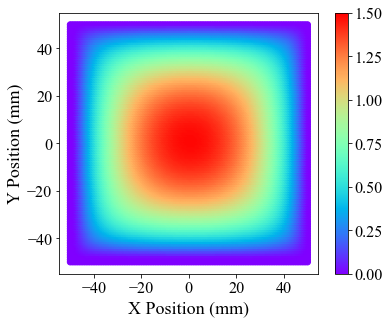

In [57]:
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
surf = ax.scatter(X, Y, c = -U3, vmin=0, vmax=1.5, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf, ticks=[0,0.25,0.5,0.75,1.0,1.25,1.5])
#cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
plt.savefig('Defection-U-FE.png', dpi=600, transparent=True)
plt.show()

In [62]:
X = X.reshape(101,101)
Y = Y.reshape(101,101)
W = W.reshape(101,101)
U3 = U3.reshape(101,101)

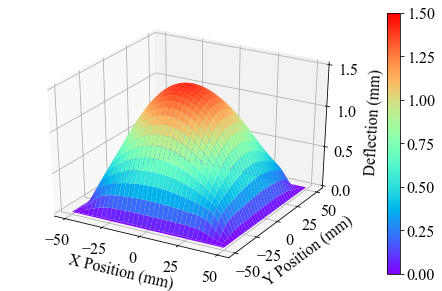

In [83]:
# Then, "ALWAYS use sans-serif fonts"
#plt.rcParams['font.family'] = 'Times New Roman'
#fig, ax = plt.subplots(figsize=(5.8, 4.8)) 
#surf = ax.scatter(X, Y, c = -U3, vmin=0, vmax=1.5, cmap=cm.rainbow)
fig = plt.figure(figsize=(8, 4.8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, W, vmin=0, vmax=1.5, cmap=cm.rainbow)
#cbar = fig.colorbar(ax)
cb = fig.colorbar(surf, ticks=[0,0.25,0.5,0.75,1.0,1.25,1.5])
#cb.ax.locator_params(nbins=7)
cb.ax.tick_params(labelsize=16)
#cb.set_label(label =r'$\sigma_xx (MPa)$', fontsize=16)
#cb.set_label(fontsize=16)
#ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=16, labelpad=8)
ax.set_ylabel('Y Position (mm)', fontsize=16, labelpad=8)
ax.set_zlabel('Deflection (mm)', fontsize=16, labelpad=8)

ax.set_xticks(ticks=[-50, -25, 0., 25, 50])
ax.set_yticks(ticks=[-50, -25, 0., 25, 50])
ax.set_zticks(ticks=[0, 0.5, 1.0, 1.5])

for tick in ax.get_xticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
for tick in ax.get_zticklabels():
    #tick.set_fontname('Times New Roman')
    tick.set_fontsize(16)
plt.savefig('Defection-U-Energy-5-5-3D.png', dpi=600, transparent=True)
plt.show()

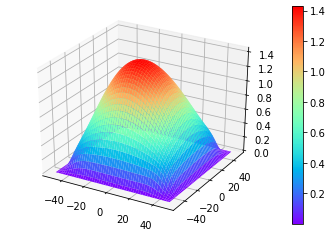

In [39]:
with torch.no_grad():
    
    a = 50
    b = 50
    h = 0.1
    
    x = np.linspace(-1,1,100)
    y = np.linspace(-1,1,100)
    X, Y = np.meshgrid(x, y)
    
    X_inp = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float32)
    W = Net_w(X_inp)*(func_w(X_inp).view(-1,1))
    U = Net_u(X_inp)*(func_u(X_inp).view(-1,1))
    V = Net_v(X_inp)*(func_v(X_inp).view(-1,1))
    #F = Net_f(X_inp)
    #_, _, _, df_xx, df_yy, df_xy, _, _, _ = derivativs(X_inp, Net_w, func_w)
    W = W.numpy().reshape(100,100)*h
    U = U.numpy().reshape(100,100)*a
    V = V.numpy().reshape(100,100)*b
    X, Y = X*a, Y*b

    #print(X.shape, Y.shape, W.shape)
    #
    #fig = plt.figure()
    #ax = Axes3D(fig)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, W, cmap=cm.rainbow)
    #cbar = fig.colorbar(ax)
    fig.colorbar(surf)
    #plt.savefig('W.png')
    plt.show()